In [11]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import cv2
import random
import os
import matplotlib.pyplot as plt

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
from detectron2.data.catalog import DatasetCatalog

In [ ]:
# x1, y1, w, h, blur, expression, illumination, invalid, occlusion, pose

In [19]:
from detectron2.structures import BoxMode

# Only for train, val dataset
def get_face_dicts(img_dir, annot_dir, phase) -> list[dict]:
    annot_file = os.path.join(annot_dir, f"{phase}.txt")
    with open (annot_file, 'r') as f:
        lines = f.readlines()

    dataset_dicts = []

    i = 0
    idx = 0
    while i < len(lines):
        record = {}

        image_path = lines[i].strip()
        image_full_path = os.path.join(img_dir, image_path)
        height, width = cv2.imread(image_full_path).shape[:2]

        record["file_name"] = image_full_path
        record["image_id"] = idx
        record["height"] = height
        record["width"] = width

        objs = []

        num_faces = int(lines[i + 1].strip())
        for j in range(num_faces):
            bbox = list(map(int, lines[i + 2 + j].strip().split())) # # even 1 bbox when num_faces = 0 
            x, y, w, h = bbox[:4]

            obj = {
                 "bbox": [x, y, w, h],
                 "bbox_mode": BoxMode.XYWH_ABS,
                 "category_id": 0,
            }           
            objs.append(obj)

        record["annotations"] = objs
        dataset_dicts.append(record)
        i += max(2 + num_faces, 3) # 3 when num_faces = 0 
        idx += 1

    return dataset_dicts

In [ ]:
img_dir = '/workspace/face_mosaic/data/widerface/train/images'
annot_dir = '/workspace/face_mosaic/data/widerface/annotations/'
phase = 'train'
dataset_dicts = get_face_dicts(img_dir, annot_dir, phase)

In [20]:
for d in ["train", "val"]:
    DatasetCatalog.register("face_" + d, lambda d=d: get_face_dicts("face/" + d))
    MetadataCatalog.get("face_" + d).set(thing_classes=["face"])
face_metadata = MetadataCatalog.get("face_train")

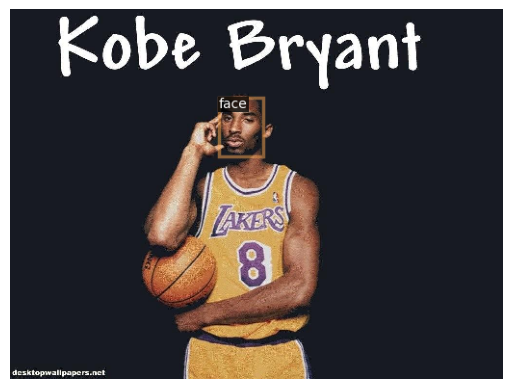

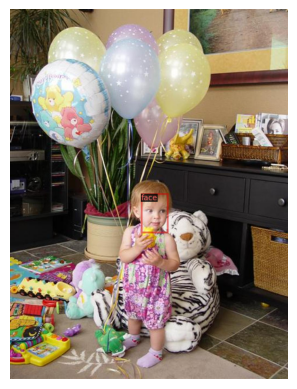

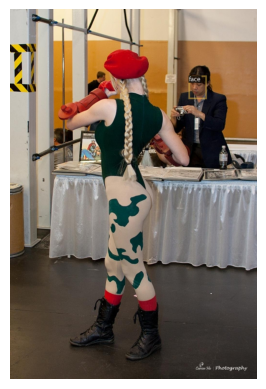

In [25]:
for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    visualizer = Visualizer(img[:, :, ::-1], metadata=face_metadata, scale=0.5)
    out = visualizer.draw_dataset_dict(d)
    plt.imshow(out.get_image()[:, :, ::-1])
    plt.axis("off")
    plt.show()